# Counting, proofreading and visualizing inputs and outputs

This notebook requires an environment where the python <a href="https://navis.readthedocs.io/en/latest/" target="_blank">navis</a> and <a href="https://fafbseg-py.readthedocs.io/en/latest/source/api.html" target="_blank">fafbseq</a> packages are installed, apart from other well-known packages listed in the import below.
<br>**CONTAINS:**
<br>A) Analysis of inputs and ouputs based on *cleft score* value
<br>B) Analysis of inputs and outputs of a list of neurons
<br>C) Proofreading predicted synapses via annotations
<br>D) Calculating and plotting synaptic cleft size ditribution between partners 
<br>E) Checking the existance of IDs from Codex in our data base 
<br>F) Updating your IDs
<br>G) Plotting our Tm9 patches / clusters
<br>H) Tm9-patch mining
<br>I) Plotting distance between presynaptic sides for selected neuron list

#### Importing packages

In [1]:
#Importing packages
import navis
import fafbseg
from fafbseg import flywire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from caveclient import CAVEclient
from visualizations.helpers.synapse_queries import combine_xyz, separate_xyz, synapse_count,filter_points, calculate_distance_nearest_neighbour

client = CAVEclient('flywire_fafb_production')

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


ModuleNotFoundError: No module named 'visualizations'

#### Setting a "secret" for accessing data

To get your personal secret, please go to: <a href="https://fafbseg-py.readthedocs.io/en/latest/source/tutorials/flywire_secret.html" target="_blank">get my secret.</a>

In [ ]:
# fafbseg.flywire.set_chunkedgraph_secret("5719b2db462d94d6aa0e903c1ff889e4") # 2022.03.11
# fafbseg.flywire.set_chunkedgraph_secret("c161f679dd3d52b1d5fc19f62cdd0164") # 2022.04.11 
fafbseg.flywire.set_chunkedgraph_secret("0c0edb71c5682a971dbadc37bcbabf29") # 2022.06.21 

## A) Analysis of inputs and ouputs based on *cleft score* value

To automatically detect of pre- and postsynaptic sites, the algorithm used in <a href="https://www.nature.com/articles/s41592-021-01183-7" target="_blank">Buhman et al. 2021.</a>
<br>A visualization of all predicted synapses can visualized by Neuroglancer <a href="http://www.tinyurl.com/tdq6xkw" target="_blank">here.</a>
<br>The algorithm returns a list of connections with two scores: the cleft score and the connection score. Number of detected synapses depend on them.

<font size="4"> The *cleft score* matters, the *connection score* not that much:</font> <br/>
<span style="color:blue">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; True positives </span> <br/>
<span style="color:Chocolate">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; False positives </span> <br/>
<span style="color:DimGrey">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Unkown </span> <br/>


<img src="./Images/proofreading/szi-chieh_labels_synapse_eval_cleft_score.png" 
     alt="cleft_score"
     width="300" height="300" style="float: left ; width: 40%; padding-left: 10%"/>
<img src="./Images/proofreading/szi-chieh_labels_synapse_eval_synful_score.png" 
     alt="connection_score"
     width="300" height="300" style="float: left ; width: 40%; padding-left: 0%"/>



### Testing different cleft score values in Tm9 inputs

In the following cells, we choose different *cleft score* values to get the total number of inputs and outputs of a single Tm9.

In [ ]:
#Getting inputs and outputs for one neuron with different min_score values

# FIRST, Check if root IDs are outdated (i.e. have more recent edits)
r1 = 720575940626482442 # root ID query for Tm9
print(f'ID up-to-date in FlyWire: {flywire.is_latest_root([r1])}')
# SECOND, proceed getting the neurons data if the ID is up to date
if flywire.is_latest_root([r1])[0]:
    neuron = flywire.get_mesh_neuron(r1) # mesh query
else:
    print(f'ID not up to date. Update it and run again')

# THIRD, proceed getting the neuron's inputs and outputs for a list of different min_scores 
# “Cleft score” for automatic synaptic detection, Buhmann et al., 2021
if flywire.is_latest_root([r1])[0]:
    min_score_ls = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]
    in_count_ls =[]
    out_count_ls =[]
    pre_count_ls=[]
    post_count_ls=[]
    
    for score in min_score_ls:
        # Fetch the neuron's inputs and ouputs
        inputs = flywire.synapses.fetch_synapses(neuron, pre=False, post=True, attach=True, 
                                                 min_score=score, clean=True, transmitters=False, 
                                                 neuropils=True, live_query=True, batch_size=30, 
                                                 dataset='production', progress=True)
        outputs = flywire.synapses.fetch_synapses(neuron, pre=True, post=False, attach=True, 
                                                 min_score=score, clean=True, transmitters=False, 
                                                 neuropils=True, live_query=True, batch_size=30, 
                                                 dataset='production', progress=True)
        
        # Counting inputs and ouputs per ID
        inputs_count = {}
        inputs_str = inputs.applymap(str)
        for c in inputs_str['pre'].to_list():
            inputs_count[c] = inputs_count.get(c, 0) + 1
        input_count_df = pd.DataFrame(inputs_count, index=[0])
        input_count_df = input_count_df.T
        input_count_df.rename(columns={0: "counts"},inplace=True)
        input_count_df.index.names = ['presynaptic_ID']
        input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
        

        outputs_count = {}
        outputs_str = outputs.applymap(str)
        for c in outputs_str['post'].to_list():
            outputs_count[c] = outputs_count.get(c, 0) + 1
        output_count_df = pd.DataFrame(outputs_count, index=[0])
        output_count_df = output_count_df.T
        output_count_df.rename(columns={0: "counts"},inplace=True)
        output_count_df.index.names = ['postsynaptic_ID']
        output_count_df['presynaptic_ID'] = outputs_str['pre'].to_list()[0:len(output_count_df)]
        
        #Storing useful info during the for-loop
        in_count_ls.append(input_count_df['counts'].sum())
        out_count_ls.append(output_count_df['counts'].sum())
        pre_count_ls.append(len(input_count_df.index))
        post_count_ls.append(len(output_count_df.index))
        
        # Printing useful info
        #print(f"Current score = {score}")
        #print(f"Total number of inputs = {input_count_df['counts'].sum()}")
        #print(f"Total number of outputs = {output_count_df['counts'].sum()}")
        #print(f"Total number of presynaptic partners = {len(input_count_df.index)}")
        #print(f"Total number of postsynaptic partners = {len(output_count_df.index)}")

Let's now creat a pandas dataframe with the obtain lists and then generate some line plots.

In [ ]:
#Generation of pandas dataframe from lists
cleft_score_df = pd.DataFrame(list(zip(min_score_ls, in_count_ls, out_count_ls, pre_count_ls, post_count_ls)),
               columns =['Cleft_scores', 'input_count', 'output_count','pre_partner_count', 'post_partner_count'])
#print(cleft_score_df)

In [ ]:
#Plotting
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.plot(cleft_score_df['Cleft_scores'],cleft_score_df['input_count'], color=color)
    ax1.set_ylabel('inputs', color=color) 
    ax1.set_title('Inputs and outputs across cleft scores')
    ax1.set_xlabel('minimun cleft score')
    ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('outputs', color=color)  
ax2.plot(cleft_score_df['Cleft_scores'],cleft_score_df['output_count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# Saving excel files
# Setting variable
outDir = r'Z:\Connectomics data\FlyWire\Excels\min_score_50'
save_excel_file = False

if save_excel_file: 
    ## Inputs
    file_name = str(neuron.id)+'_inputs.xlsx'
    savePath = os.path.join(outDir, file_name)
    inputs_str = inputs.applymap(str)
    inputs_str.to_excel(savePath)

    file_name = str(neuron.id)+'_inputs_count.xlsx'
    savePath = os.path.join(outDir, file_name)
    input_count_str_df = input_count_df.applymap(str)
    input_count_str_df.to_excel(savePath)


    ## Outputs
    file_name = str(neuron.id)+'_outputs.xlsx'
    savePath = os.path.join(outDir, file_name)
    outputs_str = outputs.applymap(str)
    outputs_str.to_excel(savePath)

    file_name = str(neuron.id)+'_outputs_count.xlsx'
    savePath = os.path.join(outDir, file_name)
    output_count_str_df = output_count_df.applymap(str)
    output_count_str_df.to_excel(savePath)

## B) Analysis of inputs and outputs of a list of neurons

### 1. Loading IDs manually

In [2]:
# Check if root IDs are outdated (i.e. have more recent edits)
# Selecting Neurons
curr_ID_ls = [720575940622098202,
720575940625082953,
720575940631396664,
720575940610721604,
720575940632789933,
720575940646674996,
720575940620174933,
720575940628122620,
720575940620048148,
720575940637971363,
720575940625120812,
720575940631909829,
720575940609319772,
720575940623757582,
720575940631310044,
720575940645122583,
720575940620850567,
720575940631977785]   # Remaining Tm1 to proofread for sparse selection of L optic lobe

print(f'ID up-to-date in FlyWire: {flywire.is_latest_root(curr_ID_ls)}')

ID up-to-date in FlyWire: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


#### 1.1 Cheking connectivity of not-up-to-date segments

In [60]:
if not np.unique(flywire.is_latest_root(curr_ID_ls))[0]: #if not up-to-date
    # Fetch the neuron's inputs and outputs
    neurons_inputs = flywire.synapses.fetch_synapses(curr_ID_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True) #,mat= "live"
    neurons_outputs = flywire.synapses.fetch_synapses(curr_ID_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True) #, mat= "live"


### 1. Or, loading from excel file

In [ ]:
# Choose path and file
import os

dataPath = r'D:\Connectomics data\FlyWire\Excels'
dataPath = r'C:\Users\sebas\Downloads'
fileDate = '20230110'
fileName = f'Tm9 proofreadings_{fileDate}.xlsx'
fileName = f'Tm1 proofreadings_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)

In [ ]:
df = pd.read_excel(filePath)
curr_ID_ls = df["seg_id"].tolist()

In [ ]:
# Applying any filter?
filtered_df = df[(df['twigs proofread (Y/N)']== 'Y') & (df['inputs_proofread (Y/N)']!= 'Y') & (df['cluster_id']!= -1)& (df['cluster_id']!= 3)].copy()
print(len(filtered_df))

# Defining id to work with
curr_ID_ls = filtered_df["seg_id"].tolist()

### 1. Or, loading from txt file

In [22]:
# Choose path and file
import os

dataPath = r'D:\Connectomics-Data\FlyWire\Txts\cell_type_proofread'
fileDate = '20230614'
fileName = f'root_ids_KC_gamma_d_L_20230928.txt'
filePath = os.path.join(dataPath,fileName)
ids_df = pd.read_csv(filePath, sep = ",")
curr_ID_ls = ids_df.columns.tolist()
len(curr_ID_ls)

132

### 2. Updating IDs and fetching synapses

In [3]:
#Updating the IDs via Fafbseg
updated_ID_df = fafbseg.flywire.update_ids(curr_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

Updating:   0%|          | 0/132 [00:00<?, ?it/s]

In [4]:
# Fetching synapses from new IDs
ID_ls = updated_ID_df["new_id"].tolist()

if np.unique(flywire.is_latest_root(ID_ls))[0]:
    # Fetch the neuron's inputs and putputs
    neurons_inputs = flywire.synapses.fetch_synapses(ID_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
    neurons_outputs = flywire.synapses.fetch_synapses(ID_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True, mat= "live")
    #synaptic_counts = flywire.synapses.synapse_counts(root_ids, by_neuropil=False, min_score=30, live_query=True,batch_size=10, dataset='production')
else:
    print(f'IDs not up to date, analysis aborted') 
    

Fetching synapses:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/5 [00:00<?, ?it/s]

#### Selecting a neuropile of interest for synaptic counts per neuron ID

In [5]:
neurons_inputs.head()

,pre,post,cleft_score,pre_x,pre_y,pre_z,post_x,post_y,post_z,id,neuropil
2,720575940624951847,720575940606929419,153,415636,170764,199440,415628,170896,199440,1970948,PLP_R
4,720575940620896588,720575940614281214,147,423124,179980,75400,423260,179984,75360,979309,MB_PED_R
5,720575940615149836,720575940628134266,66,424344,173996,198960,424352,173888,198920,1974427,PLP_R
8,720575940624611405,720575940608126386,144,419100,171208,198240,419200,171164,198280,1978118,PLP_R
11,720575940620236270,720575940636555182,137,424072,181720,74320,423928,181720,74320,979280,MB_PED_R


In [7]:
neurons_inputs.neuropil.unique()

['PLP_R', 'MB_PED_R', 'ICL_R', 'MB_ML_R', 'CRE_R', ..., 'MB_CA_R', 'NA', 'MB_VL_R', 'SIP_R', 'SPS_R']
Length: 12
Categories (12, object): ['CRE_R', 'ICL_R', 'MB_CA_R', 'MB_ML_R', ..., 'SCL_R', 'SIP_R', 'SMP_R', 'SPS_R']

In [8]:
# Selecting inputs from a single neuropile
neuropile = ['ME_R','ME_R'] # String. 'LO_R', 'ME_R', ...
#or
neuropile_list = ['ME_R','LO_R']
neuropile_list = ['ICL_R','PLP_R','MB_CA_R','SCL_R']

neuropile_neurons_inputs = neurons_inputs[(neurons_inputs['neuropil'].isin(neuropile_list))]
no_neuropile_neurons_inputs = neurons_inputs[~(neurons_inputs['neuropil'].isin(neuropile))]


In [11]:
neuropile_neurons_inputs.neuropil.unique().tolist()

['PLP_R', 'ICL_R', 'SCL_R', 'MB_CA_R']

### 2.1. For all inputs

In [9]:
# LOOPING. Counting inputs and ouputs per ID, option joining dataframes
final_input_df = pd.DataFrame()
for n in neurons_inputs['post'].unique():
    inputs_count = {}
    curr_inputs = neurons_inputs[neurons_inputs['post'] == n]
    inputs_str = curr_inputs.applymap(str)
    
    for c in inputs_str['pre'].to_list():
        inputs_count[c] = inputs_count.get(c, 0) + 1
    input_count_df = pd.DataFrame(inputs_count, index=[0])
    input_count_df = input_count_df.T
    input_count_df.rename(columns={0: "counts"},inplace=True)
    input_count_df.index.names = ['presynaptic_ID']
    input_count_df = input_count_df.sort_values(by="counts",ascending=False)
    input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
    final_input_df = final_input_df.append(input_count_df)
    #print(f'Counting done for: {n}')
input_count_str_df = final_input_df.applymap(str)
input_count_str_df.head()

,counts,postsynaptic_ID
presynaptic_ID,,
720575940617261910,68,720575940623757582
720575940618782021,24,720575940623757582
720575940620405780,14,720575940623757582
720575940639823413,12,720575940623757582
720575940632304203,6,720575940623757582


### 2.2 Or, for a selection of all inputs.

In [12]:
# LOOPING. Counting inputs and ouputs per ID, option joining dataframes
#For "no_neuropile_neurons_inputs"

final_input_df = pd.DataFrame()
for n in neuropile_neurons_inputs['post'].unique():
    inputs_count = {}
    curr_inputs = neuropile_neurons_inputs[neuropile_neurons_inputs['post'] == n]
    inputs_str = curr_inputs.applymap(str)
    
    for c in inputs_str['pre'].to_list():
        inputs_count[c] = inputs_count.get(c, 0) + 1
    input_count_df = pd.DataFrame(inputs_count, index=[0])
    input_count_df = input_count_df.T
    input_count_df.rename(columns={0: "counts"},inplace=True)
    input_count_df.index.names = ['presynaptic_ID']
    input_count_df = input_count_df.sort_values(by="counts",ascending=False)
    input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
    final_input_df = final_input_df.append(input_count_df)
    #print(f'Counting done for: {n}')
input_count_str_df = final_input_df.applymap(str)
input_count_str_df.head()

,counts,postsynaptic_ID
presynaptic_ID,,
720575940622446106,34,720575940606929419
720575940640715392,32,720575940606929419
720575940635718255,28,720575940606929419
720575940624547622,11,720575940606929419
720575940624951847,3,720575940606929419


### 2.3. For all outputs

In [ ]:
# LOOPING. Counting outputs and ouputs per ID, option joining dataframes
final_output_df = pd.DataFrame()
for n in neurons_outputs['pre'].unique():
    outputs_count = {}
    curr_outputs = neurons_outputs[neurons_outputs['pre'] == n]
    outputs_str = curr_outputs.applymap(str)
    
    for c in outputs_str['post'].to_list():
        outputs_count[c] = outputs_count.get(c, 0) + 1
    output_count_df = pd.DataFrame(outputs_count, index=[0])
    output_count_df = output_count_df.T
    output_count_df.rename(columns={0: "counts"},inplace=True)
    output_count_df.index.names = ['postsynaptic_ID']
    output_count_df = output_count_df.sort_values(by="counts",ascending=False)
    output_count_df['presynaptic_ID'] = outputs_str['pre'].to_list()[0:len(output_count_df)]
    final_output_df = final_output_df.append(output_count_df)
    #print(f'Counting done for: {n}')
output_count_str_df = final_output_df.applymap(str)
output_count_str_df.head()

### 3. Adding useful information to the dataframe

In [13]:
# Selecting dataframe
partner_ID = input_count_str_df.index.tolist()
#partner_ID = output_count_str_df.index.tolist()

In [14]:
#Updating the IDs via Fafbseg

updated_ID_df = fafbseg.flywire.update_ids(partner_ID, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

partner_ID_ls = updated_ID_df["new_id"].tolist()

Updating:   0%|          | 0/2118 [00:00<?, ?it/s]

In [15]:
# Identifying user-based annotations about cell identity

identification_df = flywire.find_celltypes(partner_ID_ls, user=None, exact=False, case=False, regex=True, update_roots=False)
identification_no_duplicates_df = identification_df.drop_duplicates(subset='pt_root_id', keep='last', inplace=False, ignore_index=False).copy()

In [16]:
identification_no_duplicates_df

,id,created,superceded_id,pt_position_x,pt_position_y,pt_position_z,tag,user_id,pt_supervoxel_id,pt_root_id
14631,14620,2022-02-07 05:29:37.108930+00:00,NaN,717736,263252,85480,"MeMe; I only identified it, have not actively ...",100,82968735383706792,720575940621570496
15371,15360,2022-02-07 05:29:37.915431+00:00,NaN,325360,246624,136800,aMe12_R;aMe12; Branches incomplete,100,76213061199313634,720575940640715392
15373,15362,2022-02-07 05:29:37.917627+00:00,NaN,326600,245588,122280,aMe12_R;aMe12; Branches incomplete,100,76213061132395554,720575940609627403
15833,15820,2022-02-07 05:29:38.420314+00:00,NaN,508308,363480,127680,SEZ ventral median (VM) OA cluster; Monastirio...,1062,79381647551715982,720575940623164515
15838,15825,2022-02-07 05:29:38.425718+00:00,NaN,516536,360872,122520,SEZ ventral median (VM) OA cluster; Monastirio...,1062,79522316253720323,720575940613635737
...,...,...,...,...,...,...,...,...,...,...
115803,140047,2023-07-13 18:51:39.721242+00:00,NaN,789168,265824,153720,#temp_NewType Medulla Tangential 102_7; Mt102_7,27,84165072955737627,720575940633292113
116104,140049,2023-07-13 18:51:39.991173+00:00,NaN,779904,289132,150680,#temp_NewType Medulla Tangential 102_7; Mt102_7,27,84024679064668954,720575940632823144
134123,145868,2023-07-27 04:22:40.744486+00:00,NaN,315360,219776,131120,aMe10-like,4287,76071911393891188,720575940609382155
136301,121853,2023-06-17 09:10:23.153722+00:00,NaN,407524,181668,224960,Trissin neuron,2927,77619336839822413,720575940628731140


In [17]:
# Adding info to the current data set. The function:

def update_dataframe_single_column(source_df, target_df, reference_column):
    # Create a dictionary mapping from the reference column to the source DataFrame
    reference_dict = source_df.groupby(reference_column).first().reset_index().to_dict(orient='records')
    reference_dict = {row[reference_column]: row for row in reference_dict}

    # Update the target DataFrame based on the reference column
    for i, row in target_df.iterrows():
        ref = row[reference_column]
        if ref in reference_dict:
            source_row = reference_dict[ref]
            target_df.loc[i] = source_row

    return target_df


In [18]:
# Run only for inputs


# Selecting dataframes and resetting index
source_df = identification_no_duplicates_df.copy()
source_df.reset_index(inplace = True, drop = True)
target_df = input_count_str_df.copy()
target_df.reset_index(inplace = True, drop = True)


# Adding columns for the function to properly work
target_df['partner_ID'] = input_count_str_df.index.astype(str)
source_df['partner_ID'] = identification_no_duplicates_df['pt_root_id'].tolist()
target_df['name'] = None
source_df['name'] = identification_no_duplicates_df['tag'].tolist()
target_df['author'] = None
source_df['author'] = identification_no_duplicates_df['user_id'].tolist()

# Function inputs
source_cols = ['name', 'author','partner_ID']
target_cols = ['name', 'author', 'partner_ID']
reference_column = 'partner_ID'

source_df = source_df[source_cols].copy()
target_df = target_df[source_cols].copy()

source_df = source_df.astype(str)
target_df = target_df.astype(str)


# Running the function and compleating the dataset
result_df = update_dataframe_single_column(source_df, target_df,reference_column)
result_df['counts'] = input_count_str_df['counts'].tolist()
result_df['postsynaptic_ID'] = input_count_str_df['postsynaptic_ID'].tolist()
result_df.head()




,name,author,partner_ID,counts,postsynaptic_ID
0,VPNl&d1_lateral; right,1063,720575940622446106,34,720575940606929419
1,aMe12_R;aMe12; Branches incomplete,100,720575940640715392,32,720575940606929419
2,None,None,720575940635718255,28,720575940606929419
3,APL-RHS,74,720575940624547622,11,720575940606929419
4,putative CL063,1232,720575940624951847,3,720575940606929419


In [21]:
len(result_df.postsynaptic_ID.unique())

132

In [20]:
# Run only for outputs


# Selecting dataframes and resetting index
source_df = identification_no_duplicates_df.copy()
source_df.reset_index(inplace = True, drop = True)
target_df = output_count_str_df.copy()
target_df.reset_index(inplace = True, drop = True)


# Adding columns for the function to properly work
target_df['partner_ID'] = output_count_str_df.index.astype(str)
source_df['partner_ID'] = identification_no_duplicates_df['pt_root_id'].tolist()
target_df['name'] = None
source_df['name'] = identification_no_duplicates_df['tag'].tolist()
target_df['author'] = None
source_df['author'] = identification_no_duplicates_df['user_id'].tolist()

# Function inputs
source_cols = ['name', 'author','partner_ID']
target_cols = ['name', 'author', 'partner_ID']
reference_column = 'partner_ID'

source_df = source_df[source_cols].copy()
target_df = target_df[source_cols].copy()

source_df = source_df.astype(str)
target_df = target_df.astype(str)


# Running the function and compleating the dataset
result_df = update_dataframe_single_column(source_df, target_df,reference_column)
result_df['counts'] = output_count_str_df['counts'].tolist()
result_df['presynaptic_ID'] = output_count_str_df['presynaptic_ID'].tolist()
result_df.head()




NameError: name 'output_count_str_df' is not defined

In [20]:
# Saving data in your computer
outDir = r'D:\Connectomics-Data\FlyWire\Excels\min-score-50'
save_excel_file = True

if save_excel_file: 
    ## Input count
    file_name = f'KC_gamma_d_neurons_input_count_L.xlsx'
    savePath = os.path.join(outDir, file_name)
    result_df.to_excel(savePath, sheet_name='Buhmann synapses')

In [19]:
#Saving more data in the same file
from openpyxl import load_workbook
updated_ID_df_str =  updated_ID_df.applymap(str)
filePath = savePath

book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

updated_ID_df_str.to_excel(writer, sheet_name='ID_update')
writer.save()
writer.close()

## C) Proofreading predicted synapses via annotations


In [ ]:
# Manually loading the URL containing synapses as annotations and notes in each

URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5833034053976064'
dict_URL = fafbseg.flywire.decode_url(URL)


In [ ]:
# For debuggin purposes

#URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5574105810075648'# OLD URL
#URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6667315345096704'# UPDATED URL
URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6516888544739328' # No segments in the dict
dict_URL = fafbseg.flywire.decode_url(URL)

### 1. Loading URLs from excell file


In [ ]:
# Loading the URLs from an excel file

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'All_Tm9_neurons_input_count_ME_R_20221017.xlsx'
filePath = os.path.join(dataPath,fileName)

df = pd.read_excel(filePath)

URL_ls = df['URL buhmann postsynapses']

#URL_ls =['https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5833034053976064','https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6635071146557440']

In [ ]:
URL_ls

In [ ]:
URL_ls = URL_ls[URL_ls.notnull()] # Getting rid of NaNs 

### 2. Extracting annotations' labels / comments

In [ ]:
# Extracting points and labels/descriptions
points = []
descriptions = []
segment_ids = []
faulty_URLs = []

for URL in URL_ls:
    dict_URL = fafbseg.flywire.decode_url(URL)
    for ann in dict_URL['annotations']:
        if 'point' in ann.keys():
            try: 
                segment_ids.append(ann['segments'])
            except:# dealing with faulty URLs with no data inside
                faulty_URLs.append(URL)
                continue
            try:
                descriptions.append(ann['description'])
            except: # dealing with faulty URLs with no data inside
                descriptions.append('NO DESCRIPTION YET')
        
            points.append(ann['point'])
            
# Splitting in pre and post IDs
pre = []
post = []
for pair in segment_ids:
    pre.append(pair[0])
    post.append(pair[1])   
    
#  len([d for d in descriptions if d.lower() == 'true' or d.lower() == 'true\n' ]) # Brief count of true synapses

In [ ]:
# Creating the summary data frame
proofread_synapses_df = pd.DataFrame()

proofread_synapses_df['post_pt_position'] = points
proofread_synapses_df['proofread_label'] = descriptions
proofread_synapses_df['pre_id'] = pre
proofread_synapses_df['post_id'] = post
    

In [ ]:
# Check if there was any faulta URL
faulty_URLs

In [ ]:
#Visualize your current annotation table
proofread_synapses_df[proofread_synapses_df['proofread_label']!= 'NO DESCRIPTION YET'].head()

### 3. Quantifiying and showing annotation proofread status

In [ ]:
# Current total number of synapses proofread as TRUE from all links in the file:
len([d for d in descriptions if d.lower() == 'true' or d.lower() == 'true\n' ])

In [ ]:
# Current total number of synapses proofread as FALSE from all links in the file:
len([d for d in descriptions if d.lower() == 'false' or d.lower() == 'false\n' ])

In [ ]:
# Current total number of synapses proofread as FALSE NEGATIVE from all links in the file:
len([d for d in descriptions if d.lower() == 'false negative' or d.lower() == 'false negative\n' ])

### 4. Comparing annotation points from 2 URLs

In [ ]:
# Compare number as well as XYZ location

## D) Calculating and plotting synaptic cleft size ditribution between partners 

In [ ]:
# TO BE DONE
# 1. Load Tm9 ID's from excel file. 
# 2. Get main input (probably L3)
# 3. Get individual synapses (pre and post sites)
# 4. Calculate the distance between the two points
# 5. Plot the distance ditribition for a given Tm9-L3 pair
# 6. Plot the median of all Tm9-L3 distribution as a distribution

## E) Checking the existance of IDs from Codex in our data base 

In [ ]:
#Loading Codex file

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'root_ids_Tm9_447.txt'
filePath = os.path.join(dataPath,fileName)

#Read txt file
from numpy import loadtxt
codex_ID_ls = list(loadtxt(filePath, comments="#", delimiter=",", unpack=False, dtype='str'))


In [ ]:
#Loading your IDs

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Tm9 proofreadings.xlsx'
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)
your_ID_ls = df["seg_id"].astype(str).tolist()



In [ ]:
# Updatind IDs using FAFBSEG
new_codex_ID_df = flywire.update_ids(codex_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_codex_ID_ls = new_codex_ID_df["new_id"].tolist()

new_your_ID_df = flywire.update_ids(your_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_your_ID_ls = new_your_ID_df["new_id"].tolist()

In [ ]:
#Checking the new IDs in codex ID list with respect to your ID list
print(f"Expected lenght for ID_diference: {len(new_codex_ID_ls)-len(new_your_ID_ls)}")
ID_diference = set(new_codex_ID_ls) - set(new_your_ID_ls)
ID_diference_ls = list(ID_diference)
print(f"Current difference: {len(ID_diference_ls)}")

In [ ]:
#Checking in URL
old_url = flywire.encode_url(your_ID_ls)
print(f'CURRENT old segment IDs: {old_url}')
new_url = flywire.encode_url(new_your_ID_ls)
print(f'CURRENT new segment IDs: {new_url}')
new_url = flywire.encode_url(ID_diference_ls)
print(f'ADD segments: {new_url}')


In [ ]:
# Currently, CAVE update not needed:

In [ ]:
# # Updating  chunkedgraph module of CAVE
# codex_ID_ls_int = list(map(int,codex_ID_ls))
# new_codex_ID_ls_int = list(map(client.chunkedgraph.get_latest_roots,codex_ID_ls_int))

# your_ID_ls_int = list(map(int,your_ID_ls))
# new_your_ID_ls_int = list(map(client.chunkedgraph.get_latest_roots,your_ID_ls_int))


In [ ]:
# #Checking the new IDs in codex ID list with respect to your ID list
# print(f"Expected lenght for ID_diference: {len(new_codex_ID_ls_int)-len(new_your_ID_ls_int)}")

In [ ]:
# # Putting the new IDs into a list and getting a new neuroglancer URL
# new_your_ID_ls_arr = np.concatenate(new_your_ID_ls_int, axis=0 )
# new_your_IDs_ls = new_your_ID_ls_arr.tolist()
# old_url = flywire.encode_url(your_IDs_ls)
# print(f'OLD segments: {old_url}')
# new_url = flywire.encode_url(new_your_IDs_ls)
# print(f'NEW segments: {new_url}')

In [ ]:
# # Putting the new IDs into a list and getting a new neuroglancer URL
# new_codex_ID_ls_arr = np.concatenate(new_codex_ID_ls_int, axis=0 )
# new_codex_IDs_ls = new_codex_ID_ls_arr.tolist()
# old_url = flywire.encode_url(codex_IDs_ls)
# print(f'OLD segments: {old_url}')
# new_url = flywire.encode_url(new_codex_IDs_ls)
# print(f'NEW segments: {new_url}')

## F) Updating your IDs

In [ ]:
#Loading your IDs

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Tm9 proofreadings.xlsx'
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)
your_ID_ls = df["seg_id"].astype(str).tolist()

#Updating the IDs
new_your_ID_df = flywire.update_ids(your_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)


In [ ]:
# Saving data in your computer
outDir = r'C:\Users\sebas\Downloads'
save_excel_file = True
new_your_ID_df = new_your_ID_df.astype(str)

if save_excel_file: 
    ## Input count
    file_name = f'Update_IDs.xlsx'
    savePath = os.path.join(outDir, file_name)
    new_your_ID_df.to_excel(savePath)

## G) Plotting our Tm9 patches /clusters or neuron types

In [ ]:
#Loading your IDs

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Tm9 proofreadings_20221212.xlsx' # For Tm9 pacthes
#fileName = 'All_Tm9_neurons_input_count_ME_R_20230110.xlsx' # For neuron types
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)


### 0. Plotting all twig-proofread neurons

### 1. Plotting all clusters

In [ ]:
# Filter by cluster ID  and generate a Neuroglancer URL

cluster_ids = df["cluster_id"].unique() # For Tm9 patches

for c_id in cluster_ids:
    temp_df = df[df["cluster_id"] == c_id].copy()
    print(f'Number of IDs in cluster {c_id}: {len(temp_df)}')
    temp_url = flywire.encode_url(temp_df["seg_id"].tolist())
    print(f'Cluster {c_id} URL: {temp_url}')
    

### 1. Or, plotting all neuron types

In [ ]:
#Deletting spaces from symbol strings
symbol_no_Spaces = df.symbol.str.strip()
df["symbol"] = symbol_no_Spaces
guess_no_Spaces = df.guess.str.strip()
df["guess"] = guess_no_Spaces

In [ ]:
symbol_ids = df["symbol"].unique() # For identified inputs
guess_ids = df["guess"].unique() # For identified inputs

In [ ]:
guess_ids

In [ ]:
# Generating URLs for each neuron type
for s_id in symbol_ids:
    temp_df = df[df["symbol"] == s_id].copy()
    print(f'Repetitions in the data set for {s_id}: {len(temp_df)}')
    temp_url = flywire.encode_url(temp_df["presynaptic_ID"].tolist())
    print(f'Symbol {s_id} URL: {temp_url}')

In [ ]:
# Generating URLs for each neuron type
for g_id in guess_ids:
    temp_df = df[df["guess"] == g_id].copy()
    print(f'Repetitions in the data set for {g_id}: {len(temp_df)}')
    temp_url = flywire.encode_url(temp_df["presynaptic_ID"].tolist())
    print(f'Guess {g_id} URL: {temp_url}')

## H) Tm9-patch mining

### 1.1 Visualizing neuron of interest to mine

In [ ]:
# Load neuron from data base
reference_neuron_type = 'Tm16'
import os

dataPath = r'D:\Connectomics data\FlyWire\Excels'
fileDate = '20221216'
fileName = f'All_Tm9_neurons_input_count_ME_R_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)
data_base_df = pd.read_excel(filePath)

In [ ]:
#Filtering the dataframe with  the "reference_neuron_type"
reference_neuron_type_df = data_base_df[data_base_df['symbol'] == reference_neuron_type].copy()
# Creting a Neuroglancer view
url = flywire.encode_url(reference_neuron_type_df["presynaptic_ID"].tolist())
print(f'Neurons URL: {url}')

In [ ]:
reference_neuron_type_df.head()

### 1.2 Loading data set

In [ ]:
# Upload all presynaptic inputs for all Tm9 belonging to a patch in a single dataframe
#Loading your IDs

# Choose path and file
import os

dataPath = r'D:\Connectomics data\FlyWire\Excels'
dataPath = r'C:\Users\sebas\Downloads'
fileDate = '20230109'
fileName = f'Tm9 proofreadings_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)


### 2. Cluster selection

In [ ]:
# Selecting cluster based on cluster ID
c_id = 2.0
filtered_df = df[df["cluster_id"] == c_id].copy()
segmentIDs = filtered_df["seg_id"].tolist()


In [ ]:
# Updating the IDs
new_segmentIDs_df = flywire.update_ids(segmentIDs, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_segmentIDs = new_segmentIDs_df["new_id"].tolist()


### 3. Finding other Tm9 based on popular presynaptic neurons

In [ ]:
# Building the common presynapses dataframe (no Buhmann cleft_score filter applied)

pre_synapses = flywire.synapses.fetch_synapses(new_segmentIDs, pre=False, post=True, attach=True, 
                                             min_score=0, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
post_synapses = flywire.synapses.fetch_synapses(new_segmentIDs, pre=True, post=False, attach=True, 
                                             min_score=0, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

In [ ]:
# Selecting inputs from a single neuropile
neuropile = 'ME_R' # String. 'LO_R', 'ME_R', ...
neuropile_pre_synapses = pre_synapses[pre_synapses['neuropil'] == neuropile].copy()
neuropile_post_synapses = post_synapses[post_synapses['neuropil'] == neuropile].copy()

In [ ]:
# Getting synaptic counts

# Using FAFseg function
synaptic_counts = fafbseg.flywire.synapses.synapse_counts(new_segmentIDs, by_neuropil=False, 
                                        min_score=0,mat='live', batch_size=10, dataset='production')

In [ ]:
# Using my own function
# Getting synapse_count data frame, among other interesting ones
#Combining x,y,z columns for future purposes
combine_xyz(pre_synapses) 
combine_xyz(post_synapses)
count_pre, count_post, synapses_count_updated = synapse_count(pre_synapses, post_synapses)

In [ ]:
print(len(count_pre['presynaptic_ID'].unique()))
index = count_pre.index
print(len(index.unique()))

### 3.1 Getting the most popular presynaptic partners among the neurons in the patch

In [ ]:
#Pair-wise comparisons to find common presynaptic ids and rank them by popularity

count_pre.sort_index(ascending=True)
index_ids = count_pre.index.unique().tolist()
popular_pre_ids_df = pd.DataFrame()
for i in range(len(index_ids)):
    print(f'Comparing: {index_ids[0]}')
    reminding_ids = [s for s in index_ids if s != index_ids[0]]
    #Creating reference df to be compared
    reference_df = count_pre[count_pre.index == index_ids[0]].copy()
    #Pair-wise comparison with other dataframes
    common_df = pd.DataFrame()
    for r_id in reminding_ids:
        compare_to_df = count_pre[count_pre.index == r_id].copy()
        curr_comparison_df = reference_df[reference_df['presynaptic_ID'].isin(compare_to_df['presynaptic_ID'])]
        data_frames = [common_df, curr_comparison_df]
        common_df = pd.concat(data_frames)
        popular_pre_ids = common_df['presynaptic_ID'].value_counts()
        # Putting together all the pair/wise comparisons in a single dataframe
        popular_pre_ids_df = pd.concat([popular_pre_ids_df, popular_pre_ids.to_frame()])
        
    #Removing the id that has done all comparisons
    print(f'Done: {index_ids[0]}')
    index_ids.remove(index_ids[0])
        
        


In [ ]:
# Popularity rank
popular_pre_ids_df.index.value_counts().to_frame(name ='popularity rank')

In [ ]:
# Choosing some postsynaptic partners from the most popular Tm9 presynaptic parters to uncover other Tm9s
popular_pre_ids = [720575940630334720,720575940631727146,720575940626719065,720575940628005007,720575940623001599,720575940614448746]


### 3.2 Connectivity of the popular presynaptic partners

In [ ]:
# Average connectivity with those Tm9s
popular_id_count_ls = []
for p_id in popular_pre_ids:
    
    #Retrieve all postsynaptic partners with min cleft_score 50!:
    post_synapses = flywire.synapses.fetch_synapses(p_id, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
    post_count_ls = []
    for post_id in new_segmentIDs:
        temp_post_synapses = post_synapses[post_synapses['post']==post_id].copy()
        temp_count = len(temp_post_synapses)
        post_count_ls.append(temp_count)
    popular_id_count_ls.append(post_count_ls)
    
    


In [ ]:
popular_id_count_ls 

In [ ]:
# For specific popular presynaptic partner, based on counts, retrieve postsynaptic parters where we might find other Tm9s
p_id = [720575940614448746]

# Synaptic counts
pre_synapses = flywire.synapses.fetch_synapses(p_id, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
post_synapses = flywire.synapses.fetch_synapses(p_id, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

In [ ]:
#Neuropile filter
# Selecting inputs from a single neuropile
neuropile = 'ME_R' # String. 'LO_R', 'ME_R', ...
neuropile_pre_synapses = pre_synapses[pre_synapses['neuropil'] == neuropile].copy()
neuropile_post_synapses = post_synapses[post_synapses['neuropil'] == neuropile].copy()

In [ ]:
# Using FAFseg function
synaptic_counts = fafbseg.flywire.synapses.synapse_counts(p_id, by_neuropil=True, 
                                        min_score=50,mat='live', batch_size=10, dataset='production')


In [ ]:
synaptic_counts

In [ ]:
# Using my own function
# Getting synapse_count data frame, among other interesting ones
#Combining x,y,z columns for future purposes
combine_xyz(neuropile_pre_synapses) 
combine_xyz(neuropile_post_synapses)
count_pre, count_post, synapses_count_updated = synapse_count(neuropile_pre_synapses, neuropile_post_synapses)

In [ ]:
#Getting postsynaptic dis by filtering connectivity
count_post['counts'] = count_post['counts'].astype('int')
post_id_ls = count_post[(count_post['counts']>=5) & (count_post['counts']<=8)]['postsynaptic_ID'].tolist()

#Generate neuroglancer link to visually rvaluate the presence of other Tm9s
url = flywire.encode_url(post_id_ls)
print(f'Postynaptic segments: {url}')


In [ ]:

#Existing
Tm9_ids = [720575940624502013,
720575940617720413,
720575940628205800,
720575940631746090,
720575940633161005,
720575940622801366,
720575940619775281,
720575940612306650,
720575940622355226]

new_Tm9_ids_df = flywire.update_ids(Tm9_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)


In [ ]:
flywire.encode_url(Tm9_ids)

In [ ]:
new_Tm9_ids_df

## I) Plotting distance between presynaptic sides for selected neuron list

In [244]:
# Loading list from txt file

dataPath = r'D:\Connectomics-Data\FlyWire\Txts\cell_type_proofread'
Neuron_name = 'C3'
fileName = f'root_ids_{Neuron_name}_R.txt'
num_neurons = 100
low_thr = 200
upp_thr = 1500
buhmann_min_score = 150
buhmann_max_score = 155
_color = '#ffff99' #7fc97f (L3), #beaed4 (Mi4), #fdc086 (Tm16), #ffff99 (C3)
filePath = os.path.join(dataPath,fileName)
ids_df = pd.read_csv(filePath, sep = ",")
curr_ID_ls = ids_df.columns.tolist()
curr_ID_ls = curr_ID_ls[0:num_neurons]

In [245]:
# Getting presynaptic sites and calculaing distances

distance_list = []
points_list = []
cleft_score_list = []
neurons_outputs_df = pd.DataFrame()
_round = 0
for _id in curr_ID_ls: # loop across postsynaptic ids.
    _round += 1
    if _round % 5 == 0:
        print(f'Round {_round}, getting outputs from: {curr_id}')
    if flywire.is_latest_root([_id])[0]:
        curr_id = _id
        
    else:
        updated_ID_df = flywire.update_ids(_id, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
        curr_id = updated_ID_df["new_id"][0]
        #print(f'Getting inputs from: {curr_id}')
    
    #Getting presynaptic sites as points
    curr_neurons_outputs = flywire.synapses.fetch_synapses(curr_id, pre=True, post=False, attach=True, 
                                             min_score= 0 , clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
    
    #Saving the cleft_score
    cleft_score_list.append(curr_neurons_outputs['cleft_score'].tolist())
    
    #Filtering and saving dataframe
    curr_neurons_outputs =curr_neurons_outputs[(curr_neurons_outputs['cleft_score'] > buhmann_min_score) & (curr_neurons_outputs['cleft_score'] < buhmann_max_score)]
    neurons_outputs_df.append(curr_neurons_outputs)
    
    #Getting points in a list
    combine_xyz(curr_neurons_outputs)
    points = curr_neurons_outputs['pre_pt_position'].tolist()
    #Discarding duplicates
    points = filter_points(points, low_thr)
    points_list.append(points)
    
    #Calculating distances betweeen nearest presynaptic sites
    distance_list.append(calculate_distance_nearest_neighbour(points, lower_threshold = low_thr, upper_threshold = upp_thr))

    


Round 5, getting outputs from: 720575940612298389
Round 10, getting outputs from: 720575940622971928
Round 15, getting outputs from: 720575940620701889
Round 20, getting outputs from: 720575940628767248
Round 25, getting outputs from: 720575940626279196
Round 30, getting outputs from: 720575940615314498
Round 35, getting outputs from: 720575940655640993
Round 40, getting outputs from: 720575940621954081
Round 45, getting outputs from: 720575940621423296
Round 50, getting outputs from: 720575940611846769
Round 55, getting outputs from: 720575940613592434
Round 60, getting outputs from: 720575940622704922
Round 65, getting outputs from: 720575940618886747
Round 70, getting outputs from: 720575940610718328
Round 75, getting outputs from: 720575940624999438
Round 80, getting outputs from: 720575940608410307
Round 85, getting outputs from: 720575940612544921
Round 90, getting outputs from: 720575940614046947
Round 95, getting outputs from: 720575940632959535


In [248]:
curr_neurons_outputs['cleft_score'].unique()

array([153, 151, 152, 154], dtype=int64)

In [249]:
import itertools
# Getting everying in a single list
distance_list_flat = list(itertools.chain.from_iterable(distance_list))
print(f'Total measurements: {len(distance_list_flat)}')
points_list_flat = list(itertools.chain.from_iterable(points_list))
cleft_score_list_flat = list(itertools.chain.from_iterable(cleft_score_list))

Total measurements: 1176


#### Visualizations

<IPython.core.display.Javascript object>


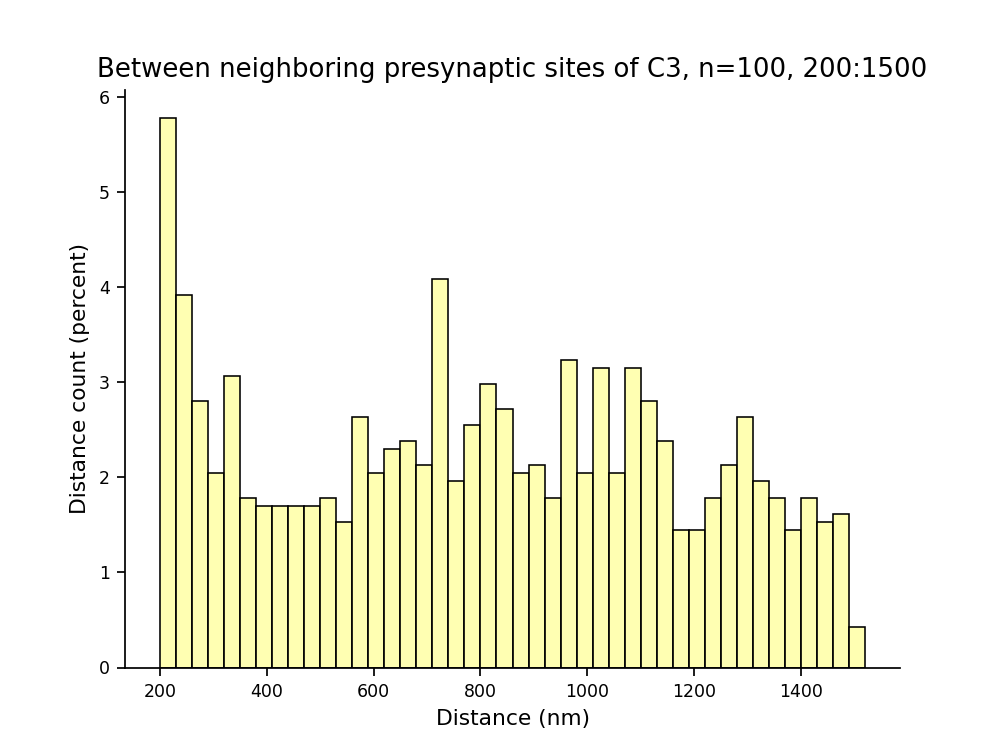

In [250]:
import seaborn as sns

# Visualizing the minimum ditance between points
fig, axs = plt.subplots(1,1)
sns.histplot(data = distance_list_flat,binwidth= 30, stat="percent", common_norm=False, color = _color, ax=axs)
axs.set_title(f'Between neighboring presynaptic sites of {Neuron_name}, n={num_neurons}, {low_thr}:{upp_thr}')
axs.set_ylabel('Distance count (percent)', size=10)
axs.set_xlabel('Distance (nm)', size=10)
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)
sns.despine(bottom = False, left = False)

<IPython.core.display.Javascript object>


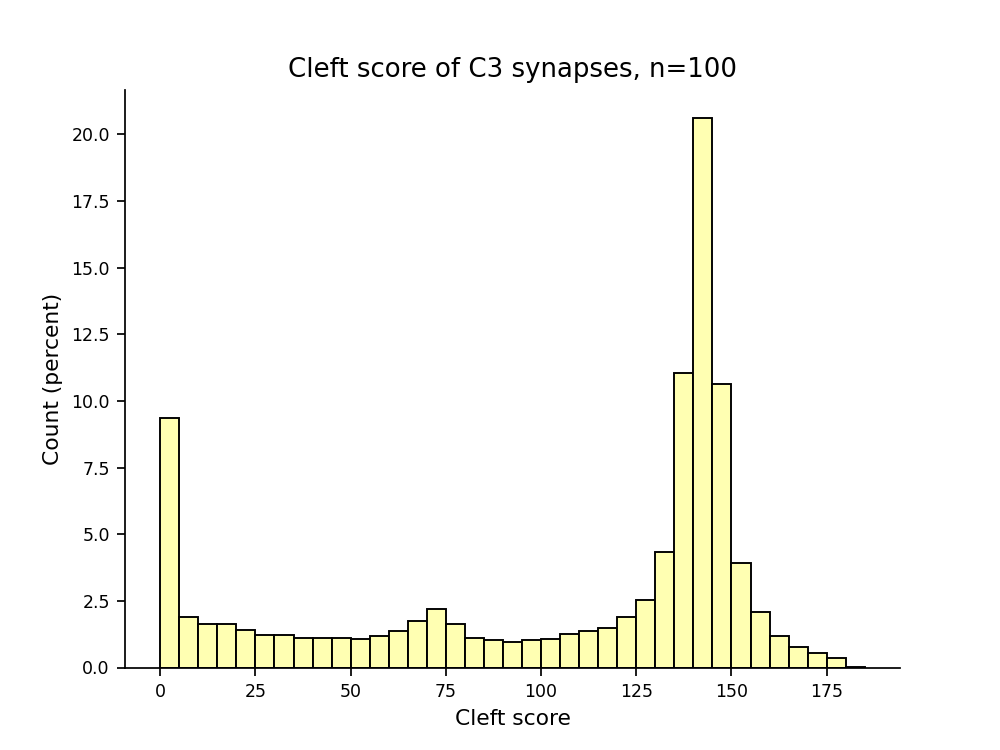

In [251]:
fig, axs = plt.subplots(1,1)
sns.histplot(data = cleft_score_list_flat,binwidth= 5, stat="percent", common_norm=False, color = _color, ax=axs)
axs.set_title(f'Cleft score of {Neuron_name} synapses, n={num_neurons}')
axs.set_ylabel('Count (percent)', size=10)
axs.set_xlabel('Cleft score', size=10)
axs.tick_params(axis='x', labelsize=8)
axs.tick_params(axis='y', labelsize=8)
sns.despine(bottom = False, left = False)

<IPython.core.display.Javascript object>


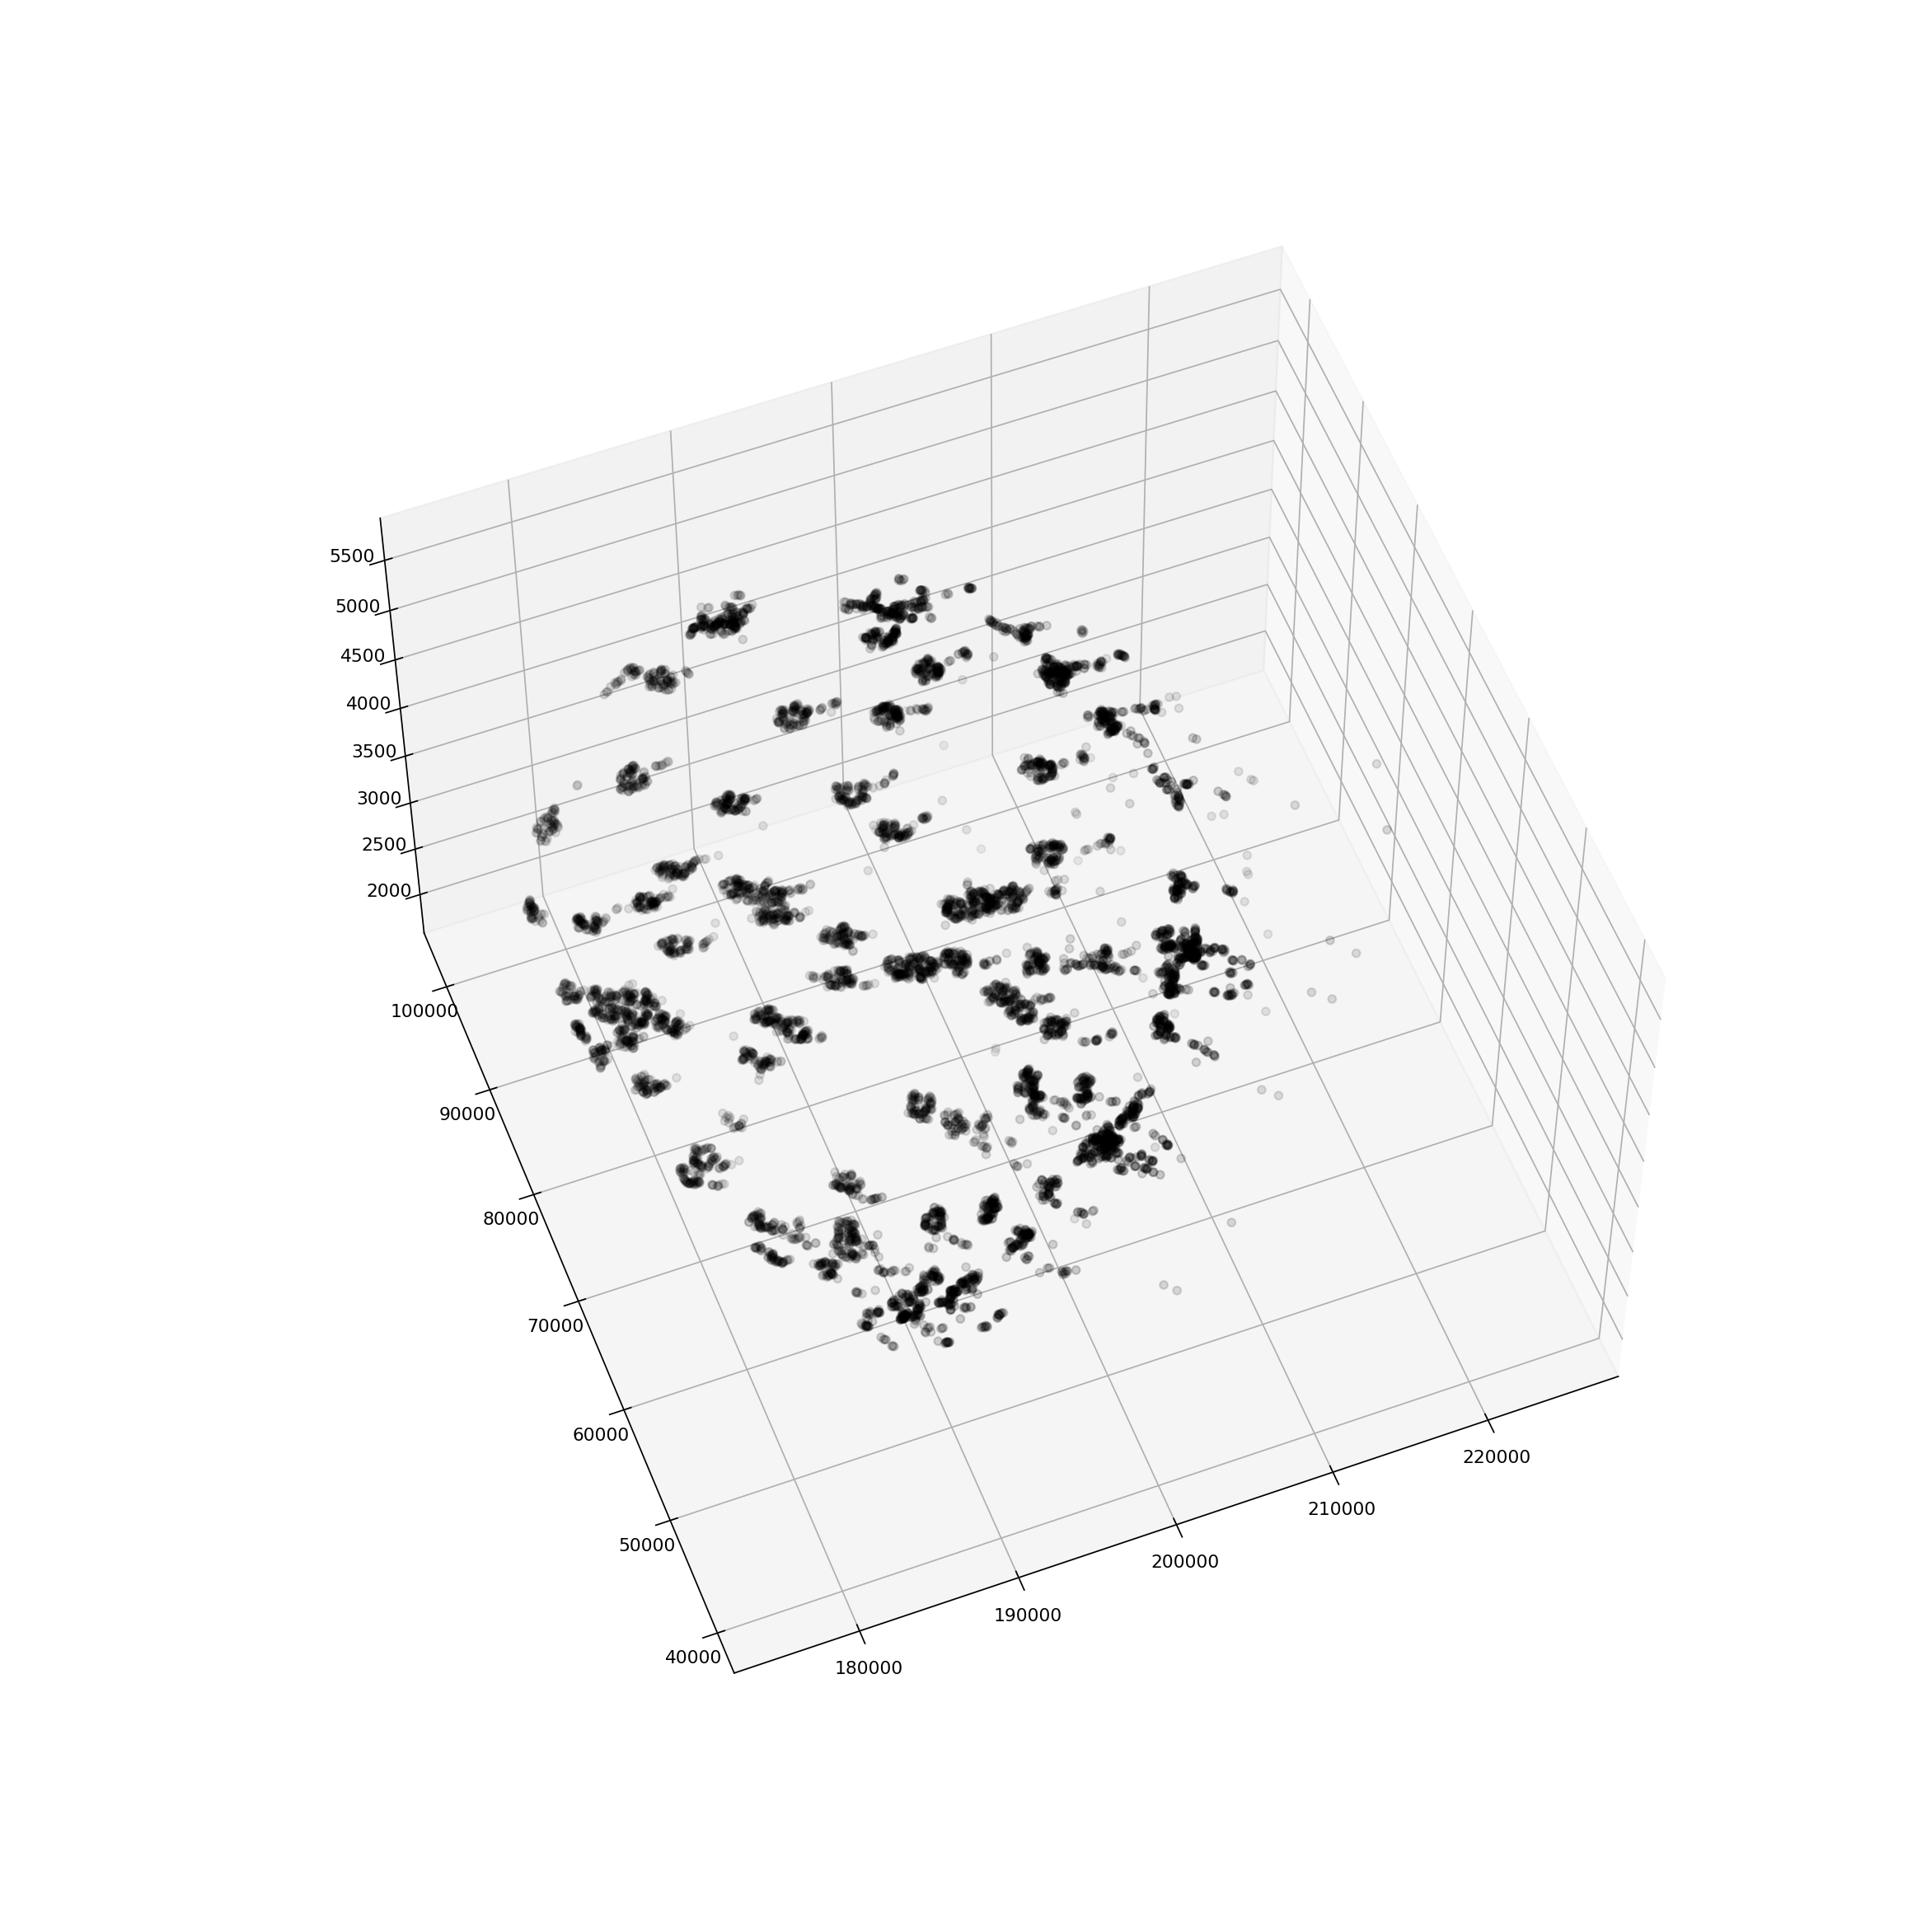

In [216]:
%matplotlib notebook

# Visualizing points (presynaptic sites)
fig = plt.figure(figsize=(15,15))
ax  = fig.add_subplot(projection='3d')
ax.scatter(np.array(points_list_flat)[:,0],np.array(points_list_flat)[:,1],np.array(points_list_flat)[:,2],'.',color=[0,0,0,0.2])


In [87]:
# Checking measurements:
temp_list_point = [[195109, 49929, 4600],[195151, 49932, 4600],
                   [195109, 49980, 4600],[195143, 49996, 4600],
                   [195223, 49969, 4600],[195233, 49938, 4600],
                  [195192, 49889, 4600],[195227, 49901, 4600],
                  [195196, 50054, 4600],[195193, 50010, 4600],
                  [195141, 50061, 4600],[195102, 50060, 4601],
                  [195154, 50039, 4601],[195138, 50011, 4603],
                  [195130, 49977, 4603],[195160, 49969, 4605],
                  [195153, 50022, 4605],[195137, 49998, 4607]]

#Original ploints in https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6276792698535936
temp_list_point = filter_points(temp_list_point, low_thr)
temp_list_point

[[195227, 49901, 4600], [195137, 49998, 4607]]

In [89]:
temp_distances = calculate_distance_nearest_neighbour(temp_list_point, lower_threshold = 0, upper_threshold = 3000)
temp_distances

[598.7854373646708, 598.7854373646708]